# Women's voices before and after #MeToo

## Introduction
In this project, we will use the [Quotebank dataset](#https://dl.acm.org/doi/pdf/10.1145/3437963.3441760), an open corpus of 178 million quotations attributed to the speakers who uttered them, extracted from 162 million English news articles published between 2008 and 2020. We will here restrict our analysis to articles published between 2015 and 2020.


## Preprocessing
We are provided with one dataset per year, which are pretty large (from 792,3Mo to 4,84Go). The datasets provided to us follow the pattern below: 

```
root
 |-- quoteID: string 
 |-- quotation: string 
 |-- speaker: string 
 |-- qids: list
 |-- date: string 
 |-- numOccurrences: int
 |-- probas: list
 |-- urls: list
 |-- phase: string 
```

1. Since our analysis will be based on the difference between male and female speakers, we need to keep only the quotations for which the speakers are known. We therefore dropped the quotations for which the speaker is unknown, and made the choice to keep only the quotations for which the probability that it is the correct speaker is greater than 0.7.


2. To further reduce the datasets, we removed columns of no interest to our analysis: urls, probas, phase and quoteID. We splitted the dataset of 2017 in two: January-October (date of the emergence of the movement) and October-December. After that, we removed the date, still only knowing the year of the dataset will be enough for our analysis. Steps 1 and 2 were performed using Google colab. 
The code for these two first steps is available [here](src/Reduce_data.ipynb).


3. Next, in order to have useful information about the speakers, we used additional speaker metadata available for ~9M unique Wikidata entities (identified by their QID) in the form of a .parquet file named speaker_attributes.parquet. We decided to keep the following attributes: 'gender', 'date_of_birth', 'occupation', 'id', 'ethnic_group', 'academic_degree', 'occupation' and 'religion'. For each dataset, we computed the current age of the speaker the year of the quotation, and thus transformed the column 'date_of_birth' by a column 'age'. Thus, after merging, the datasets follow the following pattern:
```
root
 |-- quotation: string 
 |-- speaker: string 
 |-- qids: list
 |-- numOccurrences: int
 |-- gender: ndarray
 |-- age: int
 |-- occupation: ndarray
 |-- ethnic_group: ndarray
 |-- academic_degree: ndarray
 |-- religion: ndarray
```


4. Then, we dropped the quotations for which the gender is not known, since we will build all our analyses on it. We then replaced all the wikicodes in the dataset with readable information, using a [dictionnary](data/wikidata_labels_descriptions_quotebank.csv.bz2) linking wikidata labels and descriptions. The speakers for which the year of birth is not known are also removed. 

The code for step 3 and 4 is available [here](src/get_attributes.ipynb)

## Imports

In [1]:
import pandas as pd
import bz2
import json
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from utils import quotes_by_gender
from collections import Counter

## Datasets

In [2]:
DATA_FOLDER = 'data/'


DATA_2015 = DATA_FOLDER+"sample-2015.json.bz2"
DATA_2016 = DATA_FOLDER+"sample-2016.json.bz2"
DATA_2017_BEFORE = DATA_FOLDER + "sample-2017-before.json.bz2"
DATA_2017_AFTER = DATA_FOLDER + "sample-2017-after.json.bz2"
DATA_2018 = DATA_FOLDER+"sample-2018.json.bz2"
DATA_2019 = DATA_FOLDER+"sample-2019.json.bz2"
DATA_2020 = DATA_FOLDER+"sample-2020.json.bz2"


## Wikidata attributes and dictionnary

In [3]:
WIKIDATA_LABELS = DATA_FOLDER + "wikidata_labels_descriptions_quotebank.csv.bz2"
SPEAKER_ATTRIBUTES_DATA = DATA_FOLDER+"speaker_attributes.parquet"

Load the data:

In [4]:
wiki_labels = pd.read_csv(WIKIDATA_LABELS, compression='bz2', index_col='QID')

In [7]:
quotes_2015 = pd.read_json(DATA_2015)
quotes_2016 = pd.read_json(DATA_2016)
quotes_2017_before = pd.read_json(DATA_2017_BEFORE)
quotes_2017_after = pd.read_json(DATA_2017_AFTER)
quotes_2018 = pd.read_json(DATA_2018)
quotes_2019 = pd.read_json(DATA_2019)
quotes_2020 = pd.read_json(DATA_2020)

In [8]:
quotes_2017 = pd.concat([quotes_2017_before, quotes_2017_after])

In [9]:
years = [2015, 2016, 2017, 2018, 2019, 2020]
quotes_years = [quotes_2015, quotes_2016, quotes_2017, quotes_2018, quotes_2019, quotes_2020]

In [10]:
quotes_before = pd.concat([quotes_2015, quotes_2016, quotes_2017_before], ignore_index=True)
quotes_after_shortterm = pd.concat([quotes_2017_after, quotes_2018], ignore_index=True)
quotes_after_longterm = pd.concat([quotes_2019, quotes_2020], ignore_index=True)
quotes_after = pd.concat([quotes_after_shortterm, quotes_after_longterm], ignore_index=True)

In [11]:
periods = ['Before #MeToo', 'After #MeToo (short term)', 'After #MeToo (long term)']
quotes_periods = [quotes_before, quotes_after_shortterm, quotes_after_longterm]

In [12]:
quotes_before.head()

,quotation,speaker,qids,numOccurrences,gender,age,occupation,ethnic_group,academic_degree,religion
0,"Once you're at Triple-A, you're an injury away...",Theo Epstein,Q1057736,1,male,42,"[executive, president, businessperson]",None,None,None
1,This enhances the interaction between the ligh...,David Hunger,Q42419043,1,male,38,[researcher],None,None,None
2,These events certainly do help Hong Kong to ma...,Allan Zeman,Q2837795,1,male,66,"[fashion designer, justice of the peace, busin...",None,None,None
3,One of the joys of living in Corpus Christi is...,Craig Henderson,Q1138558,1,male,28,[association football player],None,None,None
4,"We must deduct points, relegate a team [ to a ...",Sepp Blatter,Q483437,33,male,79,"[sports official, economist, politician, ice h...",[Swiss],None,None


In [13]:
by_gender_years = []
for year, quotes in zip(years, quotes_years):
    by_gender_years.append(quotes_by_gender(quotes, year, major_only = False, others_grouped = True))

quotes_by_gender_years = pd.concat(by_gender_years, ignore_index = True)

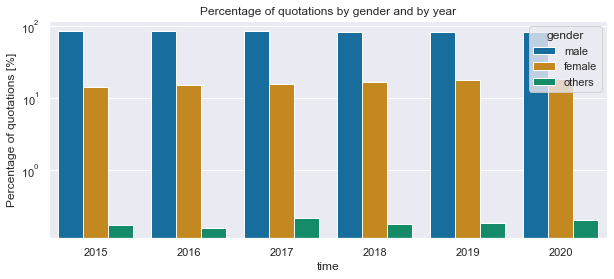

In [15]:
sns.set(rc = {'figure.figsize':(10,4)})
sns.set_palette('colorblind')

ax = sns.barplot(x = quotes_by_gender_years['time'], y = quotes_by_gender_years['count']*100, hue = quotes_by_gender_years['gender'], data = quotes_by_gender_years)
ax.set(yscale="log");
ax.set(ylabel='Percentage of quotations [%]')
ax.set_title('Percentage of quotations by gender and by year');

**Be careful, this plot has log scale in y-axis.**

By plotting the percentage of quotes by gender for every year from 2015 to 2020, we clearly see that the 'male' gender is the most represented and is the one for which most of the quotes are related.
We can also see the proportion of speakers having a different gender than 'male' or 'female' is really low. For this reason, and since our analysis will mainly focus of the 'female' gender and its differences with the 'male' gender, we will discard these speakers for further analysis.

In [28]:
#Drop the rows having a gender other than the 2 most represented
for year, quotes in zip(years, quotes_years):
    quotes.drop(quotes[
        quotes['gender'].isin(quotes_by_gender(quotes, major_only = True)['gender']) == False].index, inplace = True)

In [29]:
for period, quotes in zip(periods, quotes_periods):
    quotes.drop(quotes[
        quotes['gender'].isin(quotes_by_gender(quotes, major_only = True)['gender']) == False].index, inplace = True)

Let's look at the percentage of quotations by gender for every year, now that we have only 'male' and 'female' genders.

In [30]:
by_gender_years = []
for year, quotes in zip(years, quotes_years):
    by_gender_years.append(quotes_by_gender(quotes, year, major_only = False, others_grouped = True))

quotes_by_gender_years = pd.concat(by_gender_years, ignore_index = True)

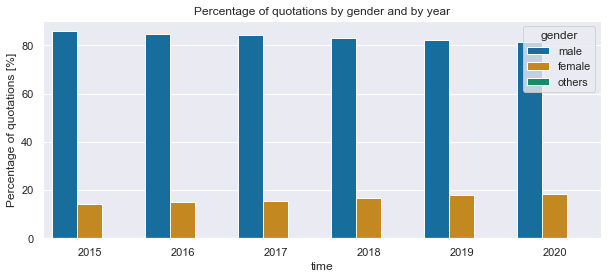

In [31]:
sns.set(rc = {'figure.figsize':(10,4)})
sns.set_palette('colorblind')

ax = sns.barplot(x = quotes_by_gender_years['time'], y = quotes_by_gender_years['count']*100, hue = quotes_by_gender_years['gender'], data = quotes_by_gender_years)
ax.set(ylabel='Percentage of quotations [%]')
ax.set_title('Percentage of quotations by gender and by year');

Looking at this plot, we observe a clear difference between male and female percentage of quotations. Indeed, around 80% of all reported quotations are told by males. However, looking at the females, we can observe a little increase of their percentage of quotations during time. 

Let's now take a look a little bit closer at the impact of the #MeToo movement by separating time into 3 categories:

-before #MeToo: from January 2015 to October 2017

-after #MeToo (short term): from October 2017 to December 2018

-after #MeToo (longterm): from January 2019 to December 2020


In [32]:
by_gender_periods = []
for period, quotes in zip(periods, quotes_periods):
    by_gender_periods.append(quotes_by_gender(quotes, period, major_only = False, others_grouped = True))

quotes_by_gender_periods = pd.concat(by_gender_periods, ignore_index = True)

In [34]:
quotes_by_gender_periods

,gender,count,time
0,male,0.850526,Before #MeToo
1,female,0.149474,Before #MeToo
2,others,0.000000,Before #MeToo
3,male,0.838579,After #MeToo (short term)
4,female,0.161421,After #MeToo (short term)
5,others,0.000000,After #MeToo (short term)
6,male,0.818454,After #MeToo (long term)
7,female,0.181546,After #MeToo (long term)
8,others,0.000000,After #MeToo (long term)


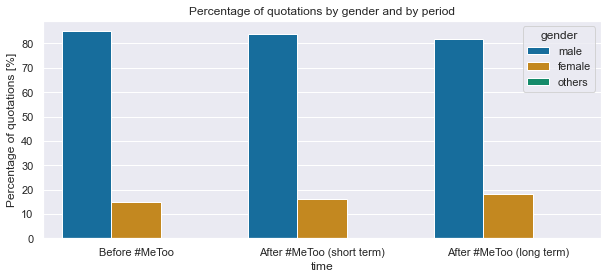

In [33]:
ax = sns.barplot(x = quotes_by_gender_periods['time'], y = quotes_by_gender_periods['count']*100, hue = quotes_by_gender_periods['gender'], data = quotes_by_gender_periods)
#ax.set(yscale="log");
ax.set(ylabel='Percentage of quotations [%]')
ax.set_title('Percentage of quotations by gender and by period');

Here again we can observe a little increase in the percentage of female quotations: before the movement the percentage was around 15%, and it lies around 18% long after the movement.

# A PARTIR DE LA J'AI PAS FINI (Lisa)

In [16]:
#Count the number of occurences by gender (quotations*occurences)
citations_by_gender = gender_groups.numOccurrences.sum().sort_values(ascending = False)
citations_by_gender

gender
male      270685
female     62856
Name: numOccurrences, dtype: int64

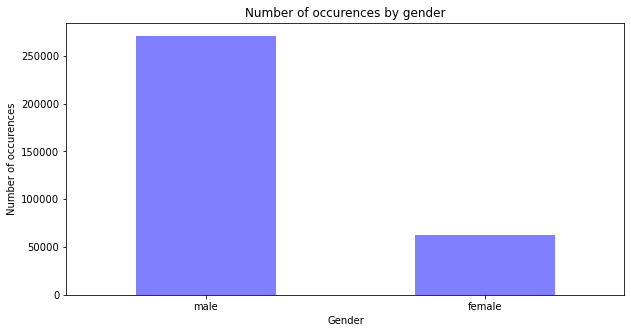

In [17]:
pl = citations_by_gender.plot(kind="bar", x=citations_by_gender.index, y=citations_by_gender.values, figsize=(10, 5), log=False, \
                        alpha=0.5, rot=0,color="blue")
pl.set_xlabel("Gender")
pl.set_ylabel("Number of occurences")
pl.set_title('Number of occurences by gender');

In [18]:
#GroupBy qids in order to get unique speakers. We add gender in the groupBy, but since we already assigned one 
#gender per speaker, it is just to provide the information in the indexing. 
unique_speaker = df_MF.groupby(['qids','gender']).mean()

In [19]:
#Let's check that the speakers are unique. 
unique_speaker.index.is_unique

True

In [20]:
print('There are', speaker_grouped.ngroups, 'unique speakers in this dataset.')

There are 11 unique speakers in this dataset.


In [21]:
#Extract the list of genders among the unique speakers
unique_speaker_gender = unique_speaker.index.to_list()

In [22]:
#Count the number of male speakers, and the number of female speakers
speaker_HF = Counter([x[1] for x in unique_speaker_gender])

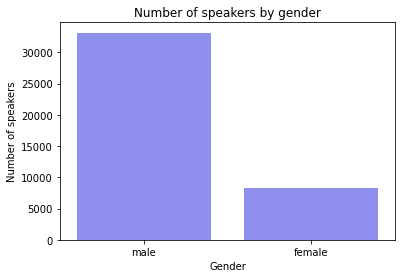

In [23]:
ax = sns.barplot(x=list(speaker_HF.keys()), y=list(speaker_HF.values()),alpha=0.5,color="blue")
plt.title('Number of speakers by gender');
plt.ylabel('Number of speakers');
plt.xlabel('Gender');